In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys

In [2]:
start_day_to_analyze = '2020-04-22'
end_day_to_analyze = '2020-04-23'

In [3]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [4]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
session = requests.session()

In [5]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [6]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
ORDER BY algo_run_id
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [7]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price
0,2407,423,CPTA,buy,525,3.62,"{'avg': 3.5019, 'rsi': 76.14765758717176, 'mac...",2020-04-22 14:12:39.671991+00:00,2020-04-22 14:12:39.844407,3.44,4.16
1,2443,423,CPTA,sell,525,3.45,"{'avg': 3.5116, 'rsi': 40.276736237629734, 'vw...",2020-04-22 14:58:51.688089+00:00,2020-04-22 14:58:51.836808,3.44,4.16
2,2428,423,CX,buy,1727,2.08,"{'avg': 2.0319, 'rsi': 73.41444273395514, 'mac...",2020-04-22 14:42:13.902493+00:00,2020-04-22 14:42:14.004793,2.03,2.25
3,2438,423,CX,sell,1727,2.03,"{'avg': 2.0377, 'rsi': 39.50766709994596, 'vwa...",2020-04-22 14:50:20.326713+00:00,2020-04-22 14:50:20.549816,2.03,2.25
4,2420,423,DENN,buy,655,9.52,"{'avg': 9.4002, 'rsi': 66.72734272925125, 'mac...",2020-04-22 14:39:22.392190+00:00,2020-04-22 14:39:22.552002,9.39,9.97
...,...,...,...,...,...,...,...,...,...,...,...
57,2415,423,VECO,buy,296,9.70,"{'avg': 9.5217, 'rsi': 70.54097156851638, 'mac...",2020-04-22 14:25:46.575762+00:00,2020-04-22 14:25:46.706069,9.38,10.66
58,2453,423,VECO,sell,296,9.66,"{'avg': 9.6342, 'rsi': 42.028681457246506, 'vw...",2020-04-22 15:58:12.524112+00:00,2020-04-22 15:58:12.677393,9.38,10.66
59,2419,423,WTI,buy,633,2.31,"{'avg': 2.2171, 'rsi': 70.43681939250297, 'mac...",2020-04-22 14:39:12.329445+00:00,2020-04-22 14:39:12.514527,2.16,2.76
60,2445,423,WTI,sell,186,2.26,"{'avg': 2.2325, 'rsi': 44.237635644033105, 'vw...",2020-04-22 15:06:16.350299+00:00,2020-04-22 15:06:16.609243,2.16,2.76


In [8]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    stop_price = row['stop_price']
    target_price = row['target_price']
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators, stop_price, target_price))

In [9]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}

for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            revnue += delta

        revenues[run_id].append(revnue)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [10]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
9,423,momentum_long,PAPER,v0.1-310-gccf8ad2,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 90}",2020-04-22 13:45:00.977151,None,None


,symbol,count,revenue
21,FULC,1,-3174.22
22,PLYM,1,-2326.06
3,HAL,4,-99.32
12,RDN,2,-94.86
13,CPTA,2,-89.25
17,CX,2,-86.35
11,DENN,2,-72.05
10,NURO,2,-51.40
19,IDRA,2,-51.17
20,HOTH,2,-34.93


TOTAL REVENUE: -5898.44 $


In [48]:

minute_history = {}
minute_history1 = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    for symbol, count in symbols.items():
        if symbol not in minute_history:
            minute_history[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=10)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')+timedelta(days=1)).date()).df
            minute_history1[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=20)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')-timedelta(days=11)).date()).df

In [49]:
minute_history['GLOP']

,open,high,low,close,volume
timestamp,,,,,
2020-04-13 08:00:00-04:00,2.2299,2.24,2.2299,2.230,4777
2020-04-13 09:06:00-04:00,2.3500,2.38,2.3400,2.340,3149
2020-04-13 09:07:00-04:00,2.3400,2.34,2.3400,2.340,2000
2020-04-13 09:17:00-04:00,2.3600,2.36,2.3600,2.360,2000
2020-04-13 09:29:00-04:00,2.3600,2.36,2.3600,2.360,195
...,...,...,...,...,...
2020-04-22 15:55:00-04:00,3.9250,3.93,3.9250,3.925,2090
2020-04-22 15:56:00-04:00,3.9200,3.93,3.9200,3.925,6606
2020-04-22 15:57:00-04:00,3.9300,3.93,3.9225,3.930,1468


In [50]:
minute_history1['GLOP']

,open,high,low,close,volume
timestamp,,,,,
2020-04-02 04:37:00-04:00,2.01,2.01,1.99,2.01,2500
2020-04-02 05:04:00-04:00,1.99,1.99,1.99,1.99,300
2020-04-02 05:05:00-04:00,1.99,1.99,1.99,1.99,600
2020-04-02 06:26:00-04:00,1.99,1.99,1.99,1.99,200
2020-04-02 06:30:00-04:00,1.99,1.99,1.99,1.99,150
...,...,...,...,...,...
2020-04-09 16:57:00-04:00,2.25,2.25,2.25,2.25,200
2020-04-09 18:58:00-04:00,2.25,2.25,2.25,2.25,100
2020-04-09 19:03:00-04:00,2.25,2.25,2.25,2.25,220


In [61]:
m = minute_history1['GLOP'].append(minute_history['GLOP'])

In [69]:
m[:3976]

,open,high,low,close,volume
timestamp,,,,,
2020-04-02 04:37:00-04:00,2.0100,2.0100,1.9900,2.0100,2500
2020-04-02 05:04:00-04:00,1.9900,1.9900,1.9900,1.9900,300
2020-04-02 05:05:00-04:00,1.9900,1.9900,1.9900,1.9900,600
2020-04-02 06:26:00-04:00,1.9900,1.9900,1.9900,1.9900,200
2020-04-02 06:30:00-04:00,1.9900,1.9900,1.9900,1.9900,150
...,...,...,...,...,...
2020-04-22 09:43:00-04:00,3.8500,3.9294,3.8500,3.9200,18000
2020-04-22 09:44:00-04:00,3.9100,3.9200,3.9000,3.9100,65152
2020-04-22 09:45:00-04:00,3.9050,3.9900,3.9001,3.9799,62924


In [70]:
RSI(m[:3976]['close'].dropna().between_time("9:30", "16:00"))

timestamp
2020-04-02 09:30:00-04:00          NaN
2020-04-02 09:32:00-04:00          NaN
2020-04-02 09:33:00-04:00          NaN
2020-04-02 09:34:00-04:00          NaN
2020-04-02 09:35:00-04:00          NaN
                               ...    
2020-04-22 09:43:00-04:00    79.629347
2020-04-22 09:44:00-04:00    77.856887
2020-04-22 09:45:00-04:00    81.034678
2020-04-22 09:46:00-04:00    75.993937
2020-04-22 09:47:00-04:00    77.505838
Length: 3756, dtype: float64

In [13]:
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        
        if not prev or -0.02 <= float(item - prev) / prev <= 0.02:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def find_resistance(current_value, minute_history, now):
    """calculate next resistance"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    print(f"now={now}")
    
    #print(minute_history)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    #print(f'index:{minute_history_index} data:{minute_history["close"][minute_history_index]}')
    for back_track_min in range(200, len(minute_history.index), 60):
        #print("start")
        series = (
            minute_history["close"][-back_track_min:minute_history_index].dropna().resample("5min").max()
        ).dropna()
        #print(series[0:10])
        # tlog(f"{symbol} find_resistances(): {len(series)}")

        diff = np.diff(series.values)
        #print(diff)
        high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
        #print(high_index)
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] >= current_value]
            )
            #print(f"local_maximas={local_maximas}")
            if len(local_maximas) > 0:
                return local_maximas
            continue
            
            clusters = dict(enumerate(grouper(local_maximas), 1))
            #print(f"cluster={clusters}")
            resistances = []
            for key, cluster in clusters.items():
                if len(cluster) > 1:
                    resistances.append(round(sum(cluster) / len(cluster), 2))
            resistances = sorted(resistances)

            if len(resistances) > 0:
                return resistances


    return None

def find_support(current_value, minute_history, now):
    """calculate support"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    for back_track_min in range(200, len(minute_history.index), 60):
        series = (minute_history["close"][-back_track_min:minute_history_index].resample("5min").min()).dropna()
        diff = np.diff(series.values)
        high_index = np.where((diff[:-1] <= 0) & (diff[1:] > 0))[0] + 1
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] <= current_value]
            )
            if len(local_maximas) > 0:
                return local_maximas
            
    return None

now=2020-04-22 10:04:36.877942
now=2020-04-22 10:06:19.663358
now=2020-04-22 10:52:19.790857
DKL analysis for run 423 with profit 145.88


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1025.57,-1025.57,buy,2020-04-22 14:04:36.877942,11.27,"[9.87, 10.3]","[12.1, 12.29]",91,"{'avg': 10.33, 'rsi': 68.86922895571621, 'macd': [0.23506488065924813, 0.23940187309067262, 0.25283510792337616, 0.27543567529460056, 0.2925963970208354], 'vwap': 11.2475, 'sell_macd': [0.13334294203629682, 0.13623210643888406, 0.14502584355208192, 0.1597349134642876, 0.1708103586755616], 'slow macd': [0.23480890902428797, 0.23873361708844598, 0.2445216293984327, 0.2524545081699969, 0.25986903676683504], 'macd_signal': [0.23221952535713686, 0.233655994903844, 0.23749181750775045, 0.24508058906512048, 0.2545837506562635], 'resistances': [12.1, 12.29], 'sell_macd_signal': [0.13158299404811163, 0.13251281652626612, 0.1350154219314293, 0.13995932023800095, 0.1461295279255131]}",14.39,10.23
1,-508.07,517.50,sell,2020-04-22 14:05:50.170988,11.50,None,None,45,"{'avg': 10.3593, 'rsi': 73.27331956079843, 'vwap': 11.5391, 'reasons': 'scale-out', 'movement': 0.020993788819875868, 'sell_macd': [0.13623210643888406, 0.14502584355208192, 0.1597349134642876, 0.17313763140283278, 0.19129640341465048], 'sell_macd_signal': [0.13251281652626612, 0.1350154219314293, 0.13995932023800095, 0.1465949824709673, 0.15553526665970394]}",14.39,10.23
2,25.07,533.14,sell,2020-04-22 14:06:18.429013,11.59,None,None,46,"{'avg': 10.4132, 'rsi': 78.2315993911845, 'vwap': 11.754, 'reasons': 'rsi max', 'movement': 0.03040863504423547, 'sell_macd': [0.14502584355208192, 0.1597349134642876, 0.17313763140283278, 0.19199250731075423, 0.22167172870250162], 'sell_macd_signal': [0.1350154219314293, 0.13995932023800095, 0.1465949824709673, 0.1556744874389247, 0.16887393569164008]}",14.39,10.23
3,-680.53,-705.60,buy,2020-04-22 14:06:19.663358,11.76,"[9.87, 10.3]","[12.1, 12.29]",60,"{'avg': 10.4137, 'rsi': 77.54145304590989, 'macd': [0.25283510792337616, 0.27543567529460056, 0.2961701861946242, 0.32540924531920545, 0.3668414512393845], 'vwap': 11.7991, 'sell_macd': [0.14502584355208192, 0.1597349134642876, 0.17313763140283278, 0.19199250731075423, 0.21866913129990273], 'slow macd': [0.2445216293984327, 0.2524545081699969, 0.260585550161478, 0.2709314859558596, 0.28447417780673945], 'macd_signal': [0.23749181750775045, 0.24508058906512048, 0.2552985084910212, 0.26932065585665804, 0.28882481493320333], 'resistances': [12.1, 12.29], 'sell_macd_signal': [0.1350154219314293, 0.13995932023800095, 0.1465949824709673, 0.1556744874389247, 0.1682734162111203]}",16.50,10.23
4,31.67,712.20,sell,2020-04-22 14:06:57.557186,11.87,None,None,60,"{'avg': 10.4533, 'rsi': 78.15611189869136, 'vwap': 11.8497, 'reasons': 'rsi max', 'movement': 0.004347936637087091, 'sell_macd': [0.14502584355208192, 0.1597349134642876, 0.17313763140283278, 0.19199250731075423, 0.22133406636483777], 'sell_macd_signal': [0.1350154219314293, 0.13995932023800095, 0.1465949824709673, 0.1556744874389247, 0.1688064032241073]}",16.50,10.23
5,-1165.89,-1197.56,buy,2020-04-22 14:52:19.790857,12.74,[12.16],"[12.8293, 13.41]",94,"{'avg': 12.1462, 'rsi': 63.19478801730497, 'macd': [0.06930300890889995, 0.05911528379646569, 0.05683355860813144, 0.07513894703769175, 0.10617434883249999], 'vwap': 13.008, 'sell_macd': [0.02851215287195963, 0.022731281564938755, 0.022082144422261862, 0.034796035682225224, 0.05567963879801141], 'slow macd': [0.33448890162235223, 0.32655094492946546, 0.3200033871005754, 0.3176259604261755, 0.3184492460641213], 'macd_signal': [0.08726071333354198, 0.08163162742612672, 0.07667201366252765, 0.07636540033756048, 0.08232719003654838], 'resistances': [13.41], 'sell_macd_signal': [0.0359928042573087, 0.03334049971883471, 0.03108882865952014, 0.03183027006406115, 0.03660014381085121]}",16.05,12.05
6,-518.23,647.66,sell,2020-04-22 15:10:46.754857,13.78,None,None,47,"{'avg': 12.2628, 'rsi': 74.19611793325845, 'vwap': 13.7423, 'reasons': 'scale-out', 'movement': 0.02844311377245515, 'sell_macd': [0.049038945079527, 0.054280650325

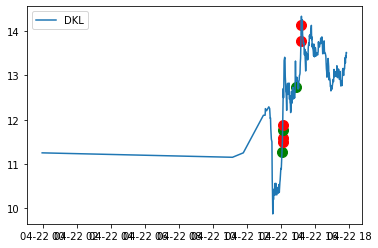

now=2020-04-22 10:40:11.890641
SBOW analysis for run 423 with profit 39.4


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-849.72,-849.72,buy,2020-04-22 14:40:11.890641,5.82,"[5.15, 5.2]",None,146,"{'avg': 5.3515, 'rsi': 67.93477502451505, 'macd': [0.04070820734959035, 0.09266832503967226, 0.1183616557080871, 0.13857880474222295, 0.1521770975211929], 'vwap': 5.8299, 'sell_macd': [0.021604986127431225, 0.05564951024781273, 0.07236408085787893, 0.08538369327016504, 0.09398879783467162], 'slow macd': [0.14965441030319493, 0.15756557320972497, 0.16179321157641358, 0.16571189331789427, 0.1689194259503921], 'macd_signal': [0.021043125678777273, 0.035368165550956274, 0.051966863582382436, 0.06928925181435054, 0.08586682095571901], 'resistances': [5.995], 'sell_macd_signal': [0.007093683725611867, 0.01680484903005204, 0.02791669539561742, 0.03941009497052694, 0.05032583554335588]}",7.78,5.18
1,-402.23,447.49,sell,2020-04-22 14:41:58.865487,6.13,None,None,73,"{'avg': 5.3813, 'rsi': 68.90553387389558, 'vwap': 5.9439, 'reasons': 'scale-out', 'movement': 0.02063571024237959, 'sell_macd': [0.05564951024781273, 0.07236408085787893, 0.08538369327016504, 0.08984334328921761, 0.1025464037808268], 'sell_macd_signal': [0.01680484903005204, 0.02791669539561742, 0.03941009497052694, 0.04949674463426508, 0.060106676463577424]}",7.78,5.18
2,-207.03,195.20,sell,2020-04-22 14:42:00.956502,6.10,None,None,32,"{'avg': 5.3833, 'rsi': 71.52886148429167, 'vwap': 6.0388, 'reasons': 'scale-out', 'movement': 0.022050420168067186, 'sell_macd': [0.05564951024781273, 0.07236408085787893, 0.08538369327016504, 0.08984334328921761, 0.10936198819641074], 'sell_macd_signal': [0.01680484903005204, 0.02791669539561742, 0.03941009497052694, 0.04949674463426508, 0.06146979334669421]}",7.78,5.18
3,-182.63,24.40,sell,2020-04-22 14:42:01.129279,6.10,None,None,4,"{'avg': 5.3833, 'rsi': 71.52886148429167, 'vwap': 6.0388, 'reasons': 'scale-out', 'movement': 0.022050420168067186, 'sell_macd': [0.05564951024781273, 0.07236408085787893, 0.08538369327016504, 0.08984334328921761, 0.10936198819641074], 'sell_macd_signal': [0.01680484903005204, 0.02791669539561742, 0.03941009497052694, 0.04949674463426508, 0.06146979334669421]}",7.78,5.18
4,-69.05,113.58,sell,2020-04-22 14:43:32.267380,6.31,None,None,18,"{'avg': 5.403, 'rsi': 73.72504918823005, 'vwap': 6.2096, 'reasons': 'scale-out', 'movement': 0.020637374202459997, 'sell_macd': [0.07236408085787893, 0.08538369327016504, 0.08984334328921761, 0.11285289728732106, 0.13234536926912455], 'sell_macd_signal': [0.02791669539561742, 0.03941009497052694, 0.04949674463426508, 0.06216797516487628, 0.07620345398572594]}",7.78,5.18
5,-11.90,57.15,sell,2020-04-22 14:43:55.098117,6.35,None,None,9,"{'avg': 5.4245, 'rsi': 73.53771933530578, 'vwap': 6.2401, 'reasons': 'scale-out', 'movement': 0.022830167399745464, 'sell_macd': [0.08538369327016504, 0.08984334328921761, 0.11285289728732106, 0.1241843303080854, 0.1469233127877967], 'sell_macd_signal': [0.03941009497052694, 0.04949674463426508, 0.06216797516487628, 0.0745712461935181, 0.08904165951237382]}",7.78,5.18
6,39.40,51.30,sell,2020-04-22 14:49:37.897251,5.13,None,None,10,"{'avg': 5.4727, 'rsi': 39.67921945996171, 'vwap': 5.1524, 'reasons': 'stopped', 'movement': -0.18803163001701212, 'sell_macd': [0.14186783206377296, 0.12273715163680166, 0.09514003504907276, 0.07206773595410176, 0.034696233594980086], 'sell_macd_signal': [0.11097712080603246, 0.1133291269721863, 0.1096913085875636, 0.10216659406087122, 0.088672521967693]}",7.78,5.18


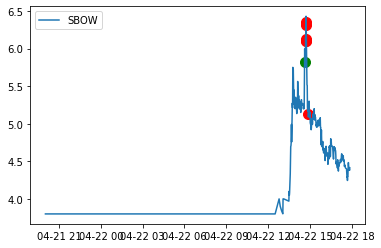

now=2020-04-22 10:05:49.817713
now=2020-04-22 10:56:04.743441
SBSW analysis for run 423 with profit -16.2


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2954.88,-2954.88,buy,2020-04-22 14:05:49.817713,6.84,[6.65],"[6.97, 7.24, 7.24, 7.28]",432,"{'avg': 6.6387, 'rsi': 72.17024651034964, 'macd': [0.0620317754431019, 0.06172504257348166, 0.06317446790271397, 0.06359012059196711, 0.06558426306255605], 'vwap': 6.84, 'sell_macd': [0.03459316113125688, 0.03444916919865726, 0.03544801744340198, 0.035765976888094464, 0.03710768584645141], 'slow macd': [0.07066882415111397, 0.07120658510296973, 0.07206726547474496, 0.0727438574273851, 0.07372980810843988], 'macd_signal': [0.06400729410218521, 0.0635508437964445, 0.0634755686176984, 0.06349847901255215, 0.06391563582255293], 'resistances': [6.97, 7.24, 7.24, 7.28, 7.35, 7.35], 'sell_macd_signal': [0.035784168112475076, 0.03551716832971151, 0.035503338152449604, 0.03555586589957858, 0.03586622988895315]}",7.50,6.62
1,-43.20,2911.68,sell,2020-04-22 14:30:24.762989,6.74,None,None,432,"{'avg': 6.6752, 'rsi': 39.970337979998874, 'vwap': 6.7537, 'reasons': 'below cost & macd negative', 'movement': -0.014619883040935621, 'sell_macd': [0.006286026075977169, 0.005387353563884645, 0.0035781625990871646, 0.002121933761594086, -0.0005987891476415541], 'sell_macd_signal': [0.010899481038143453, 0.009797055543291692, 0.008553276954450786, 0.007267008315879446, 0.005693848823175246]}",7.50,6.62
2,-3143.70,-3100.50,buy,2020-04-22 14:56:04.743441,6.89,[6.69],"[6.97, 7.24, 7.24, 7.28]",450,"{'avg': 6.6875, 'rsi': 70.97027943370462, 'macd': [0.012806923543767113, 0.01599018050147727, 0.01989740255664696, 0.024167762827145722, 0.02819533554246867], 'vwap': 6.89, 'sell_macd': [0.00794770495522723, 0.010003530120142656, 0.012514516870465009, 0.015243668664606247, 0.017795687352707645], 'slow macd': [0.032056971938523304, 0.032246066987275945, 0.03268833945398164, 0.03333084868551861, 0.03406059292663155], 'macd_signal': [0.004078616546027949, 0.0064609293371178135, 0.009148223981023643, 0.012152131750248058, 0.01536077250869218], 'resistances': [6.97, 7.24, 7.24, 7.28, 7.35, 7.35], 'sell_macd_signal': [0.0020389578832338156, 0.003631872330615584, 0.005408401238585469, 0.0073754547237896255, 0.009459501249573229]}",7.52,6.68
3,-16.20,3127.50,sell,2020-04-22 16:11:10.759448,6.95,None,None,450,"{'avg': 6.7494, 'rsi': 41.75625420472605, 'vwap': 6.9528, 'reasons': 'below cost & macd negative', 'movement': -0.010668563300142273, 'sell_macd': [0.005418283143486136, 0.003448126948265795, 0.0018681594331821927, 9.327358463373514e-05, -0.0015507059542958501], 'sell_macd_signal': [0.010003362579006322, 0.008692315452858217, 0.007327484248923012, 0.005880642116065157, 0.004394372501992956]}",7.52,6.68


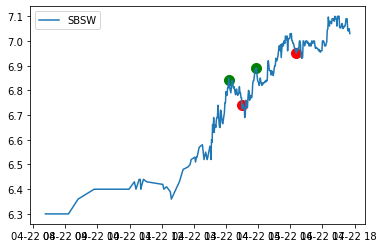

now=2020-04-22 10:11:09.902416
now=2020-04-22 10:57:23.993751
HAL analysis for run 423 with profit -99.32


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2414.84,-2414.84,buy,2020-04-22 14:11:09.902416,8.27,"[7.98, 8.025, 8.04]","[8.27, 8.27]",292,"{'avg': 8.0885, 'rsi': 72.62495021481277, 'macd': [0.035523520895962335, 0.04104204307692605, 0.04683641751412715, 0.05162418760009224, 0.057579002481118025], 'vwap': 8.2708, 'sell_macd': [0.018287887478628306, 0.02204803113238185, 0.02595401279592302, 0.02916966067925486, 0.033114715384717996], 'slow macd': [0.06661255240064001, 0.06742327884837973, 0.06844998354284382, 0.06944184582504587, 0.07080310441283011], 'macd_signal': [0.0336393141422049, 0.03511985992914913, 0.037463171446144736, 0.04029537467693424, 0.043752100237771], 'resistances': [8.39], 'sell_macd_signal': [0.016223819678758033, 0.017388661969482796, 0.01910173213477084, 0.021115317843667644, 0.023515197351877716]}",9.25,7.95
1,-58.40,2356.44,sell,2020-04-22 14:23:05.644422,8.07,None,None,292,"{'avg': 8.1012, 'rsi': 41.779273923373864, 'vwap': 8.06, 'reasons': 'below cost & macd negative', 'movement': -0.025981873111782457, 'sell_macd': [0.010971633192497166, 0.00942810953949369, 0.006284739036638953, 0.0010316615144585484, -0.0029503685224927523], 'sell_macd_signal': [0.019949360779041674, 0.017845110531132077, 0.015533036232233451, 0.012632761288678471, 0.009516135326444226]}",9.25,7.95
2,-2881.88,-2823.48,buy,2020-04-22 14:57:23.993751,8.28,"[7.98, 8.02, 8.025, 8.04]","[8.39, 8.64, 8.67]",341,"{'avg': 8.1097, 'rsi': 71.47041670643138, 'macd': [0.02709798884679948, 0.027782632882912495, 0.029597865300004855, 0.03321951046667415, 0.03690690185974255], 'vwap': 8.2836, 'sell_macd': [0.016694656496545335, 0.017064752340845146, 0.018170479591717026, 0.02044805303925834, 0.02275722646540501], 'slow macd': [0.0343727937230458, 0.034540540893667426, 0.034959502939260645, 0.03579764514443973, 0.03675781093154029], 'macd_signal': [0.02136631624790308, 0.022649579574904963, 0.02403923671992494, 0.025875291469274784, 0.028081613547368336], 'resistances': [8.39], 'sell_macd_signal': [0.013142102711706384, 0.013926632637534136, 0.014775402028370714, 0.01590993223054824, 0.017279391077519593]}",9.12,8.01
3,-99.32,2782.56,sell,2020-04-22 15:10:15.512958,8.16,None,None,341,"{'avg': 8.1177, 'rsi': 42.82396182842846, 'vwap': 8.1737, 'reasons': 'below cost & macd negative', 'movement': -0.014142291727000725, 'sell_macd': [0.013754643178682358, 0.008377637200023713, 0.00454129959067906, 0.0022721884718297503, -0.00030467978275261487], 'sell_macd_signal': [0.0164677114905992, 0.014849696632484102, 0.012788017224123094, 0.010684851473664426, 0.008486945222381017]}",9.12,8.01


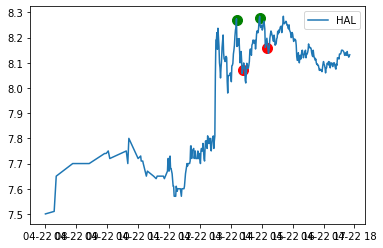

now=2020-04-22 09:48:24.063318
GLOP analysis for run 423 with profit -33.66


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1208.70,-1208.70,buy,2020-04-22 13:48:24.063318,3.95,"[3.35, 3.4169, 3.61, 3.6206, 3.63, 3.65, 3.6701, 3.69, 3.69, 3.69, 3.7, 3.87]","[4.0, 4.1, 4.1, 4.1, 4.1027]",306,"{'avg': 3.8117, 'rsi': 75.77550962622112, 'macd': [0.0615127603690091, 0.07416008012820541, 0.08242609896941966, 0.09114590177698689, 0.09694693358602713], 'vwap': 3.9437, 'sell_macd': [0.03796402805778554, 0.046006754756368284, 0.05115684368050566, 0.05657825266450223, 0.060073139500544936], 'slow macd': [0.026663284088600747, 0.030769324617347937, 0.034337865984072735, 0.038204264313099756, 0.04170197142938914], 'macd_signal': [0.051484137497988476, 0.05601932602403186, 0.06130068061310942, 0.06726972484588492, 0.07320516659391337], 'resistances': [4.0, 4.1, 4.1027], 'sell_macd_signal': [0.03214635323369023, 0.03491843353822584, 0.0381661155666818, 0.041848542986245886, 0.045493462289105696]}",4.88,3.64
1,-751.74,456.96,sell,2020-04-22 14:21:37.601157,3.84,None,None,119,"{'avg': 3.8549, 'rsi': 43.263197168123675, 'vwap': 3.84, 'reasons': 'below cost & macd negative', 'movement': -0.027848101265822864, 'sell_macd': [0.012437407514078291, 0.008799096566627806, 0.00477964522359331, 0.0021361812520912515, -0.00047088393676864015], 'sell_macd_signal': [0.017987057434306154, 0.016149465260770483, 0.01387550125333505, 0.01152763725308629, 0.009127933015115304]}",4.88,3.64
2,-33.66,718.08,sell,2020-04-22 14:21:37.769660,3.84,None,None,187,"{'avg': 3.8549, 'rsi': 43.263197168123675, 'vwap': 3.84, 'reasons': 'below cost & macd negative', 'movement': -0.027848101265822864, 'sell_macd': [0.012437407514078291, 0.008799096566627806, 0.00477964522359331, 0.0021361812520912515, -0.00047088393676864015], 'sell_macd_signal': [0.017987057434306154, 0.016149465260770483, 0.01387550125333505, 0.01152763725308629, 0.009127933015115304]}",4.88,3.64


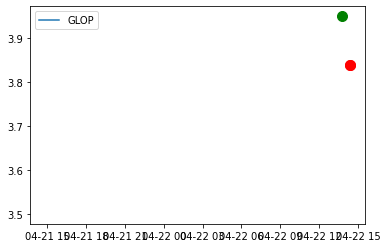

now=2020-04-22 10:39:12.514527
WTI analysis for run 423 with profit -31.65


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1462.23,-1462.23,buy,2020-04-22 14:39:12.514527,2.31,"[2.1301, 2.16, 2.1784]",[2.35],633,"{'avg': 2.2171, 'rsi': 70.43681939250297, 'macd': [0.01914382892300681, 0.021473876412676063, 0.025296291096460255, 0.027181131192343333, 0.0285235998578659], 'vwap': 2.31, 'sell_macd': [0.011861025760665278, 0.01332354905032096, 0.015749884742905174, 0.016900927039167346, 0.017692636269512008], 'slow macd': [0.012823574024231288, 0.013642919449350366, 0.014824343737795509, 0.015722848301074066, 0.01655954066688814], 'macd_signal': [0.013676447676521009, 0.01523593342375202, 0.017248004958293667, 0.0192346302051036, 0.02109242413565606], 'resistances': [2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.48, 2.52], 'sell_macd_signal': [0.008412367746082412, 0.00939460400693012, 0.010665660154125131, 0.011912713531133575, 0.013068698078809261]}",2.76,2.16
1,-1041.87,420.36,sell,2020-04-22 15:06:16.609243,2.26,None,None,186,"{'avg': 2.2325, 'rsi': 44.237635644033105, 'vwap': 2.2683, 'reasons': 'below cost & macd negative', 'movement': -0.01948051948051945, 'sell_macd': [0.0038633361532256494, 0.002758159714311592, 0.0022871370383485967, 0.0011527409656717502, -5.914947656560088e-06], 'sell_macd_signal': [0.004828762269151278, 0.004414641758183341, 0.003989140814216393, 0.003421860844507464, 0.0027363056860746594]}",2.76,2.16
2,-31.65,1010.22,sell,2020-04-22 15:06:16.658327,2.26,None,None,447,"{'avg': 2.2325, 'rsi': 44.237635644033105, 'vwap': 2.2683, 'reasons': 'below cost & macd negative', 'movement': -0.01948051948051945, 'sell_macd': [0.0038633361532256494, 0.002758159714311592, 0.0022871370383485967, 0.0011527409656717502, -5.914947656560088e-06], 'sell_macd_signal': [0.004828762269151278, 0.004414641758183341, 0.003989140814216393, 0.003421860844507464, 0.0027363056860746594]}",2.76,2.16


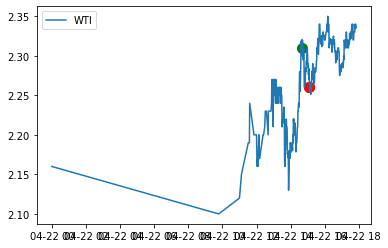

now=2020-04-22 09:47:46.738178
MCEP analysis for run 423 with profit -33.85


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1900.30,-1900.30,buy,2020-04-22 13:47:46.738178,3.10,"[2.5, 2.51, 2.51, 2.51, 2.52, 2.55, 2.57, 2.6, 2.6013, 2.61, 2.62, 2.62, 2.6201, 2.655, 2.66, 2.735, 2.76]",[3.1599],613,"{'avg': 2.9625, 'rsi': 67.42395071262658, 'macd': [0.0650534712929578, 0.06585809790465946, 0.06494824014568312, 0.07466332890835758, 0.08381716393428951], 'vwap': 3.1, 'sell_macd': [0.03937246603586164, 0.03973083253361498, 0.03897980860285655, 0.04516109114248801, 0.05094960882086985], 'slow macd': [0.033027488532666016, 0.034777751344786, 0.0361740902993275, 0.03964001575842513, 0.043245187457085166], 'macd_signal': [0.061514503868339246, 0.06238322267560329, 0.06289622616961926, 0.06524964671736692, 0.06896315016075144], 'resistances': [3.1599], 'sell_macd_signal': [0.03780940310053807, 0.03819368898715345, 0.03835091291029407, 0.03971294855673286, 0.04196028060956026]}",3.57,2.94
1,-927.22,973.08,sell,2020-04-22 13:49:11.254357,3.18,None,None,306,"{'avg': 2.9685, 'rsi': 70.95440850523103, 'vwap': 3.1615, 'reasons': 'scale-out', 'movement': 0.025806451612903247, 'sell_macd': [0.03897980860285655, 0.04516109114248801, 0.05094960882086985, 0.05687638092323377, 0.06283391267931959], 'sell_macd_signal': [0.03835091291029407, 0.03971294855673286, 0.04196028060956026, 0.04494350067229496, 0.04852158307369989]}",3.57,2.94
2,-33.85,893.37,sell,2020-04-22 14:07:07.469782,2.91,None,None,307,"{'avg': 2.9938, 'rsi': 42.696176937551634, 'vwap': 2.9181, 'reasons': 'stopped', 'movement': -0.08490566037735849, 'sell_macd': [0.024908406872091504, 0.021461245750717506, 0.018813311815222278, 0.014110852751002323, 0.007146457989908317], 'sell_macd_signal': [0.03616527313110846, 0.033224467655030274, 0.030342236487068675, 0.027095959739855405, 0.02310605938986599]}",3.57,2.94


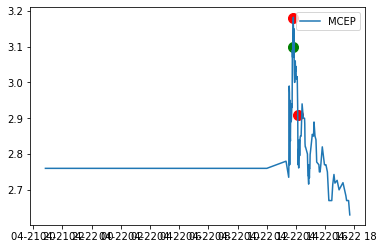

now=2020-04-22 10:25:46.706069
VECO analysis for run 423 with profit -11.84


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2871.20,-2871.20,buy,2020-04-22 14:25:46.706069,9.70,"[9.23, 9.31, 9.39, 9.44]","[9.9, 9.9, 9.91]",296,"{'avg': 9.5217, 'rsi': 70.54097156851638, 'macd': [0.015692523375417267, 0.010533890344683883, 0.01913571471838793, 0.029645568974498104, 0.04551915200735479], 'vwap': 9.6712, 'sell_macd': [0.00873803171421983, 0.0053417663795993775, 0.010937640581458297, 0.017753417354574808, 0.028028653575775664], 'slow macd': [0.010394803478467551, 0.009726742498891383, 0.01165552487234045, 0.014211105096979537, 0.0181389522287283], 'macd_signal': [0.031069153111665127, 0.02696210055826888, 0.02539682339029269, 0.026246572507133772, 0.030101088407177977], 'resistances': [9.9, 9.9], 'sell_macd_signal': [0.019403660677169136, 0.016591281817655186, 0.015460553570415808, 0.01591912632724761, 0.01834103177695322]}",10.66,9.38
1,-11.84,2859.36,sell,2020-04-22 15:58:12.677393,9.66,None,None,296,"{'avg': 9.6342, 'rsi': 42.028681457246506, 'vwap': 9.67, 'reasons': 'below cost & macd negative', 'movement': -0.0030927835051545735, 'sell_macd': [0.005030926930631452, 0.004091545764135063, 0.0027869429621372177, 0.00017573372730517178, -0.0018612570235667647], 'sell_macd_signal': [0.007015674430419327, 0.006430848697162475, 0.005702067550157423, 0.004596800785586973, 0.0033051892237562254]}",10.66,9.38


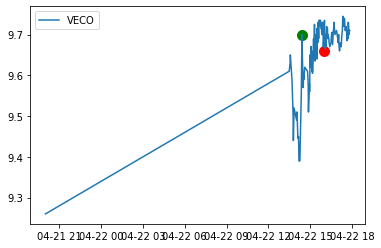

now=2020-04-22 10:39:45.967389
NGL analysis for run 423 with profit 44.68


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3540.89,-3540.89,buy,2020-04-22 14:39:45.967389,3.17,"[3.1, 3.105]",[3.24],1117,"{'avg': 3.1039, 'rsi': 70.86747038038473, 'macd': [0.008591694482996903, 0.010851433292252466, 0.013295941666543687, 0.015059634077551731, 0.01666868500836971], 'vwap': 3.1727, 'sell_macd': [0.004899230066595095, 0.006374020862348839, 0.007959909523165276, 0.009092291472851066, 0.01011632557036135], 'slow macd': [0.01592971037104851, 0.01627657613399336, 0.01672960764778786, 0.017119654462121936, 0.017531097525670614], 'macd_signal': [0.007902665958243838, 0.008492419425045564, 0.009453123873345189, 0.010574425914186497, 0.01179327773302314], 'resistances': [3.24], 'sell_macd_signal': [0.004415030389262851, 0.004806828483880048, 0.005437444691737093, 0.006168414047959888, 0.0069579963524401805]}",3.43,3.09
1,44.68,3585.57,sell,2020-04-22 14:42:35.535199,3.21,None,None,1117,"{'avg': 3.1091, 'rsi': 78.81886677852083, 'vwap': 3.2036, 'reasons': 'rsi max', 'movement': 0.01417322834645681, 'sell_macd': [0.01011632557036135, 0.010523153106468452, 0.010703497250104554, 0.01226346025488434, 0.014358711164390137], 'sell_macd_signal': [0.0069579963524401805, 0.007671027703245835, 0.00827752161261758, 0.009074709341070932, 0.010131509705734773]}",3.43,3.09


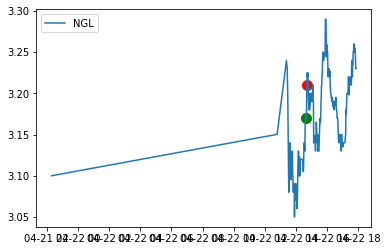

now=2020-04-22 10:43:23.778910
PUMP analysis for run 423 with profit -25.86


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1508.50,-1508.50,buy,2020-04-22 14:43:23.778910,3.50,[3.34],[3.55],431,"{'avg': 3.3685, 'rsi': 68.4465384876914, 'macd': [0.03451427844672139, 0.03385588613367618, 0.034661352143299684, 0.03638117477598746, 0.0381117346759452], 'vwap': 3.494, 'sell_macd': [0.021263749376161822, 0.02073814351306691, 0.021170942275420934, 0.022199474528223462, 0.023232103887183442], 'slow macd': [0.022445048683009894, 0.02297685190611043, 0.023771642713279473, 0.024762337266035495, 0.025794140071644378], 'macd_signal': [0.026558202954406078, 0.028017739590260098, 0.029346462100868016, 0.030753404635891903, 0.032225070643902565], 'resistances': [3.54, 3.55], 'sell_macd_signal': [0.016350427308116446, 0.01722797054910654, 0.018016564894369418, 0.018853146821140226, 0.019728938234348868]}",4.16,3.28
1,-25.86,1482.64,sell,2020-04-22 15:08:07.611805,3.44,None,None,431,"{'avg': 3.3892, 'rsi': 42.18982467494095, 'vwap': 3.4395, 'reasons': 'below cost & macd negative', 'movement': -0.017142857142857158, 'sell_macd': [0.005024183657592385, 0.004841197272168696, 0.0031396338903815213, 0.0004119269189843955, -0.0014591684732603305], 'sell_macd_signal': [0.007859202448544503, 0.007255601413269341, 0.0064324079086917774, 0.005228311710750301, 0.0038908156739481748]}",4.16,3.28


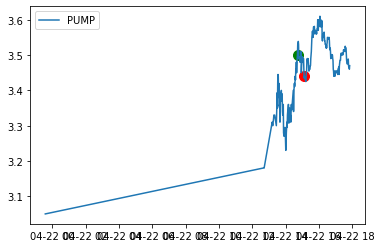

now=2020-04-22 10:10:22.544852
NURO analysis for run 423 with profit -51.4


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1547.14,-1547.14,buy,2020-04-22 14:10:22.544852,3.01,"[2.51, 2.7322, 2.8, 2.81, 2.81, 2.81, 2.82, 2.82, 2.8201, 2.84, 2.8948, 2.92]","[3.02, 3.02, 3.02, 3.02, 3.02]",514,"{'avg': 2.9381, 'rsi': 69.54944603094367, 'macd': [0.013341115130724113, 0.013165391523209724, 0.020057170559792947, 0.024829280396890585, 0.029856668099495387], 'vwap': 3.0624, 'sell_macd': [0.007071679780753737, 0.0069874117482058296, 0.011506327414425588, 0.014618387317786308, 0.017876896498095984], 'slow macd': [0.016215350999339684, 0.016308988124999146, 0.017808477558682423, 0.019079605618126827, 0.020533642900137483], 'macd_signal': [0.01678284899514016, 0.016059357500754073, 0.016858920112561848, 0.018452992169427595, 0.020733727355441153], 'resistances': [3.0886, 3.0939], 'sell_macd_signal': [0.009306779798146715, 0.008842906188158538, 0.009375590433411948, 0.010424149810286821, 0.011914699147848654]}",3.61,2.87
1,-51.40,1495.74,sell,2020-04-22 14:25:22.803745,2.91,None,None,514,"{'avg': 2.943, 'rsi': 46.34613876143564, 'vwap': 2.9309, 'reasons': 'below cost & macd negative', 'movement': -0.04082233934592589, 'sell_macd': [0.003857436362172173, 0.0023866885016397, 0.0013499149934110832, 0.0011842484286432864, -0.000279702770249024], 'sell_macd_signal': [0.007918360808138404, 0.006812026346838663, 0.005719604076153148, 0.004812532946651175, 0.0037940858032711354]}",3.61,2.87


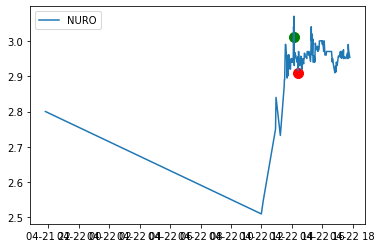

now=2020-04-22 10:39:22.552002
DENN analysis for run 423 with profit -72.05


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-6235.60,-6235.60,buy,2020-04-22 14:39:22.552002,9.52,"[9.21, 9.3, 9.315, 9.3715, 9.4]","[9.55, 9.57, 9.65, 9.65, 9.65]",655,"{'avg': 9.4002, 'rsi': 66.72734272925125, 'macd': [0.019487034107971368, 0.022184958674548838, 0.02245045560078829, 0.027986665949256917, 0.03160635592655758], 'vwap': 9.5355, 'sell_macd': [0.010699783762303738, 0.012500739144796214, 0.012702772700702525, 0.016331594007894523, 0.01868740809131708], 'slow macd': [0.0378354182078926, 0.038129713494976514, 0.038019619373264035, 0.038977074370643905, 0.039715657198108545], 'macd_signal': [0.017054941183161393, 0.018080944681438883, 0.018954846865308763, 0.020761210682098394, 0.02293023973099023], 'resistances': [9.65, 9.65, 9.65], 'sell_macd_signal': [0.008818623638124131, 0.009555046739458548, 0.010184591931707343, 0.01141399234694478, 0.01286867549581924]}",9.97,9.39
1,-72.05,6163.55,sell,2020-04-22 14:50:10.806209,9.41,None,None,655,"{'avg': 9.4069, 'rsi': 47.170673854442086, 'vwap': 9.429, 'reasons': 'below cost & macd negative', 'movement': -0.011116937598321958, 'sell_macd': [0.0049252398766874705, 0.0029211346002409044, 0.001841037831578518, 0.0004560138841593897, -0.0006810958655716348], 'sell_macd_signal': [0.011262242908143252, 0.009594021246562782, 0.008043424563565929, 0.006525942427684621, 0.00508453476903337]}",9.97,9.39


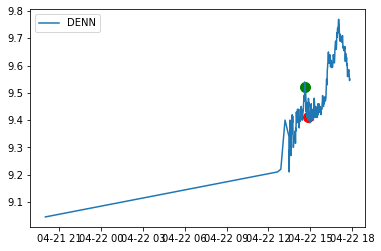

now=2020-04-22 10:44:05.040691
RDN analysis for run 423 with profit -94.86


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-6835.19,-6835.19,buy,2020-04-22 14:44:05.040691,12.97,"[11.845, 12.11, 12.13, 12.24, 12.43, 12.49, 12.59, 12.7238]","[13.11, 13.11, 13.17]",527,"{'avg': 12.7297, 'rsi': 68.80149958485082, 'macd': [0.04005168079184607, 0.041306347714444414, 0.04221748165420891, 0.043646803326055306, 0.04546582397122201], 'vwap': 12.97, 'sell_macd': [0.022822917415895816, 0.02366485982143729, 0.024273323256647217, 0.025211433423606877, 0.026394227924827263], 'slow macd': [0.06032257009783493, 0.06050008945173602, 0.060646619509920896, 0.06092434009602421, 0.06132231598896176], 'macd_signal': [0.034379325635314935, 0.03576473005114083, 0.03705528037175444, 0.038373584962614615, 0.03979203276433609], 'resistances': [13.11, 13.17], 'sell_macd_signal': [0.018846256048257397, 0.019809976802893377, 0.020702646093644146, 0.021604403559636692, 0.022562368432674805]}",13.51,12.79
1,-94.86,6740.33,sell,2020-04-22 14:50:10.652764,12.79,None,None,527,"{'avg': 12.7482, 'rsi': 38.074786615605156, 'vwap': 12.795, 'reasons': 'below cost & macd negative', 'movement': -0.013492675404780316, 'sell_macd': [0.023528738137793326, 0.01855821206371644, 0.011327176005167416, 0.004667574193241819, -0.00048364246791088306], 'sell_macd_signal': [0.023792707038646284, 0.022745808043660314, 0.020462081635961735, 0.017303180147417753, 0.013745815624352026]}",13.51,12.79


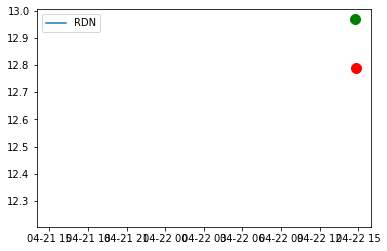

now=2020-04-22 10:12:39.844407
CPTA analysis for run 423 with profit -89.25


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1900.50,-1900.50,buy,2020-04-22 14:12:39.844407,3.62,"[3.22, 3.22, 3.24, 3.25, 3.2566, 3.27, 3.27, 3.27, 3.29, 3.3, 3.3, 3.32, 3.32, 3.33, 3.33, 3.33, 3.33, 3.345, 3.4]","[3.63, 3.64, 3.66, 3.7, 3.74]",525,"{'avg': 3.5019, 'rsi': 76.14765758717176, 'macd': [0.029554855291964888, 0.032306949038224175, 0.03648813987602573, 0.039348182385687824, 0.04592686888316422], 'vwap': 3.6116, 'sell_macd': [0.017380602614589957, 0.019128612332397488, 0.021800715848450114, 0.023599748252536745, 0.027811984564130032], 'slow macd': [0.02255766574533835, 0.02364806899219163, 0.025093261153343427, 0.02638275100468146, 0.02848654354522928], 'macd_signal': [0.030286170091120213, 0.030690325880541006, 0.03184988867963795, 0.033349547420847926, 0.03586501171331118], 'resistances': [3.7], 'sell_macd_signal': [0.018138123807767255, 0.0183362215126933, 0.019029120379844663, 0.019943245954383078, 0.021516993676332467]}",4.16,3.44
1,-89.25,1811.25,sell,2020-04-22 14:58:51.836808,3.45,None,None,525,"{'avg': 3.5116, 'rsi': 40.276736237629734, 'vwap': 3.4614, 'reasons': 'below cost & macd negative', 'movement': -0.04419889502762435, 'sell_macd': [0.009684510701898574, 0.007888310066285875, 0.004308305544168167, 0.0017224798705162137, -0.0010940398735050927], 'sell_macd_signal': [0.01558789574717855, 0.014047978611000015, 0.012100043997633645, 0.010024531172210159, 0.007800816963067109]}",4.16,3.44


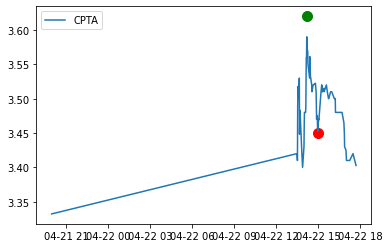

now=2020-04-22 10:43:42.160777
ENBL analysis for run 423 with profit -31.68


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1763.52,-1763.52,buy,2020-04-22 14:43:42.160777,3.34,"[3.19, 3.21]",[3.3899],528,"{'avg': 3.2542, 'rsi': 69.65488064314016, 'macd': [0.015094697516370381, 0.014840927033825224, 0.015669557829165903, 0.01933108272204942, 0.022777222364940286], 'vwap': 3.34, 'sell_macd': [0.009569640920187972, 0.009354084495778014, 0.009843857613175633, 0.012175578774613172, 0.014353860474764168], 'slow macd': [0.01381133099931997, 0.013913693107988845, 0.014225520552856974, 0.015129404146791536, 0.016096744623823156], 'macd_signal': [0.008116353198754967, 0.00946126796576902, 0.010702925938448396, 0.012428557295168601, 0.014498290309122938], 'resistances': [3.3899], 'sell_macd_signal': [0.00505031241803606, 0.005911066833584451, 0.006697624989502687, 0.007793215746524784, 0.00910534469217266]}",3.88,3.16
1,-31.68,1731.84,sell,2020-04-22 15:07:13.041175,3.28,None,None,528,"{'avg': 3.2635, 'rsi': 48.71705124596007, 'vwap': 3.29, 'reasons': 'below cost & macd negative', 'movement': -0.014970059880239469, 'sell_macd': [0.0026552153617638297, 0.0018325113281054684, 0.001136475570344686, 5.467529714975328e-05, -0.0002747103091991221], 'sell_macd_signal': [0.00537671708398731, 0.0046678759328109415, 0.00396159586031769, 0.003180211747684103, 0.002489227336307458]}",3.88,3.16


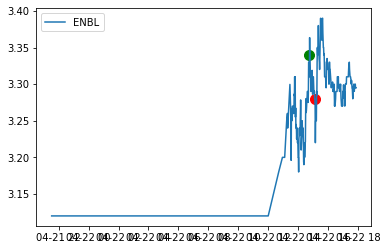

now=2020-04-22 10:26:07.017601
MGY analysis for run 423 with profit 79.1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3464.58,-3464.58,buy,2020-04-22 14:26:07.017601,4.38,[4.27],"[4.56, 4.56, 4.56, 4.595]",791,"{'avg': 4.2764, 'rsi': 71.6512257003789, 'macd': [0.026540588621587702, 0.026181317602746113, 0.026798056062596665, 0.032559910342392584, 0.036703130529214256], 'vwap': 4.3778, 'sell_macd': [0.01555415411039096, 0.015301500082865793, 0.015685126813588468, 0.019416717424364904, 0.02207228520647142], 'slow macd': [0.032753868971403755, 0.032815283607790846, 0.033059207615745656, 0.03435030410188844, 0.03548321565654877], 'macd_signal': [0.02401335193828092, 0.02444694507117396, 0.0249171672694585, 0.026445715884045318, 0.028497198813079105], 'resistances': [4.56, 4.56, 4.595], 'sell_macd_signal': [0.013852749542689197, 0.014142499650724515, 0.014451025083297306, 0.015444163551510825, 0.016769787882502944]}",4.74,4.26
1,79.10,3543.68,sell,2020-04-22 15:18:10.660564,4.48,None,None,791,"{'avg': 4.3448, 'rsi': 63.286545925597395, 'vwap': 4.4725, 'reasons': 'bail', 'movement': 0.022831050228310626, 'sell_macd': [0.007117654084689562, 0.005544521396851465, 0.0050259177258498156, 0.005595500349408589, 0.007265363428163418], 'sell_macd_signal': [0.007592426935699816, 0.007182845827930146, 0.00675146020751408, 0.0065202682358929814, 0.006669287274347069]}",4.74,4.26


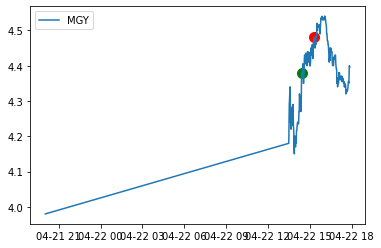

now=2020-04-22 10:23:03.887290
OSUR analysis for run 423 with profit 2.1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3005.1,-3005.1,buy,2020-04-22 14:23:03.887290,14.31,"[13.93, 13.97]",[14.47],210,"{'avg': 14.0302, 'rsi': 74.0773538109342, 'macd': [0.05813109306591002, 0.058631921412340304, 0.06314246303518622, 0.0659567909387242, 0.07299414994077047], 'vwap': 14.32, 'sell_macd': [0.0340410664696531, 0.03434388404289912, 0.03725070443707956, 0.03903198390738716, 0.04354944863870003], 'slow macd': [0.06533310818240778, 0.06591539040213235, 0.06730530236773724, 0.06847642040987445, 0.07056392018329127], 'macd_signal': [0.04702380457929965, 0.04934542794590778, 0.05210483496376347, 0.05487522615875561, 0.058499010915158585], 'resistances': [14.47], 'sell_macd_signal': [0.026523860959804517, 0.028087865576423437, 0.02992043334855466, 0.03174274346032116, 0.03410408449599693]}",15.67,13.87
1,2.1,3007.2,sell,2020-04-22 14:54:26.427550,14.32,None,None,210,"{'avg': 14.2326, 'rsi': 44.876759991330196, 'vwap': 14.3568, 'reasons': 'below cost & macd negative', 'movement': -0.017330595482546177, 'sell_macd': [0.026134169565748877, 0.016054062565103777, 0.009029900453365158, 0.0024002949058630207, -0.0019240768831760846], 'sell_macd_signal': [0.04137393923373694, 0.0363099639000103, 0.030853951210681275, 0.025163219949717625, 0.019745760583138882]}",15.67,13.87


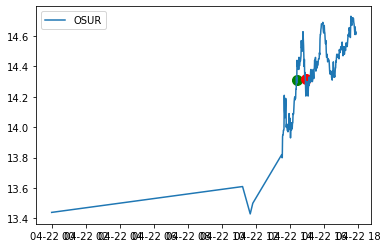

now=2020-04-22 10:42:14.004793
CX analysis for run 423 with profit -86.35


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3592.16,-3592.16,buy,2020-04-22 14:42:14.004793,2.08,"[2.0207, 2.03, 2.0301, 2.0354, 2.07, 2.08, 2.08]","[2.0862, 2.09, 2.09, 2.095, 2.095, 2.0953, 2.1, 2.1, 2.1, 2.1, 2.1, 2.13, 2.13, 2.13]",1727,"{'avg': 2.0319, 'rsi': 73.41444273395514, 'macd': [0.010798224291217018, 0.011550902080012193, 0.012407833087415998, 0.013735538770283107, 0.015018094062896559], 'vwap': 2.0805, 'sell_macd': [0.006763292743372062, 0.007216227993989577, 0.007735187565977686, 0.008558595186149986, 0.009348801186464417], 'slow macd': [0.006416098928276437, 0.006785373378817017, 0.007194233441663034, 0.007718827632323677, 0.008269093894691437], 'macd_signal': [0.007896564701268542, 0.008627432177017271, 0.009383512359097016, 0.010253917641334234, 0.011206752925646699], 'resistances': [2.13, 2.13, 2.13], 'sell_macd_signal': [0.0049685729252246695, 0.005418103938977651, 0.005881520664377658, 0.006416935568732124, 0.007003308692278583]}",2.25,2.03
1,-86.35,3505.81,sell,2020-04-22 14:50:20.549816,2.03,None,None,1727,"{'avg': 2.0377, 'rsi': 39.50766709994596, 'vwap': 2.0345, 'reasons': 'stopped', 'movement': -0.026378896882494084, 'sell_macd': [0.009203246000126342, 0.008200684596447072, 0.007053225261158591, 0.004768799477022689, 0.002667054716955608], 'sell_macd_signal': [0.008470191144609365, 0.008416289834976906, 0.008143676920213243, 0.007468701431575133, 0.006508372088651228]}",2.25,2.03


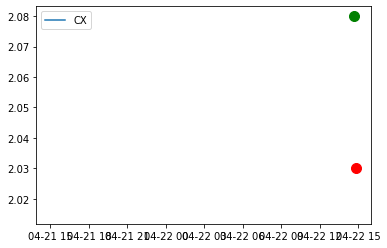

now=2020-04-22 10:22:02.564197
FHN analysis for run 423 with profit 54.75


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2923.65,-2923.65,buy,2020-04-22 14:22:02.564197,8.01,"[7.8025, 7.84, 7.87]","[8.18, 8.18, 8.18]",365,"{'avg': 7.9069, 'rsi': 66.1962263521144, 'macd': [0.020882593468456, 0.02308096124071568, 0.025736879452704642, 0.02832215008087058, 0.031221468663270358], 'vwap': 8.0013, 'sell_macd': [0.012229719324341914, 0.01365678449229879, 0.0153706432661318, 0.017025979411116943, 0.018873955895376326], 'slow macd': [0.03280410516260979, 0.033141732843893656, 0.033639259578503555, 0.034203134819616565, 0.03490711898216059], 'macd_signal': [0.0161575980775629, 0.017542270710193455, 0.019181192458695692, 0.02100938398313067, 0.023051800919158608], 'resistances': [8.18, 8.18, 8.18], 'sell_macd_signal': [0.008982431910890173, 0.009917302427171896, 0.011007970594963877, 0.01221157235819449, 0.013544049065630857]}",8.79,7.75
1,54.75,2978.40,sell,2020-04-22 14:40:13.174371,8.16,None,None,365,"{'avg': 7.9481, 'rsi': 78.39895051931694, 'vwap': 8.1605, 'reasons': 'rsi max', 'movement': 0.01935081148564287, 'sell_macd': [0.02571279612083721, 0.0272509525990845, 0.028095607613314755, 0.02890838285020436, 0.029945501439335942], 'sell_macd_signal': [0.023794815648920428, 0.024486043038953242, 0.025207955953825543, 0.02594804133310131, 0.026747533354348235]}",8.79,7.75


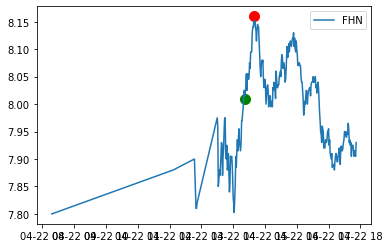

now=2020-04-22 09:51:59.002734
IDRA analysis for run 423 with profit -51.17


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1520.48,-1520.48,buy,2020-04-22 13:51:59.002734,2.08,"[1.8, 1.8, 1.95, 1.96, 1.9799, 1.99, 2.0, 2.0057, 2.01, 2.02, 2.02, 2.0217, 2.022, 2.03, 2.03, 2.04, 2.04, 2.0402, 2.0602]","[2.1, 2.1, 2.1, 2.1, 2.1, 2.108, 2.11, 2.12, 2.13, 2.13, 2.13, 2.13, 2.13, 2.14, 2.15, 2.17, 2.19]",731,"{'avg': 2.067, 'rsi': 63.19418100006845, 'macd': [0.02192643220799062, 0.024941791021977133, 0.02702001469650228, 0.03153121541362025, 0.03390858104197636], 'vwap': 2.0779, 'sell_macd': [0.014679732157589553, 0.016511352901119603, 0.017724156689569837, 0.0205169368274587, 0.021907194898184823], 'slow macd': [-0.0036248963805169954, -0.002170746581596328, -0.0008294104465931262, 0.0010457323316670486, 0.0026093151399237957], 'macd_signal': [0.010181623490693441, 0.01313365699695018, 0.0159109285368606, 0.01903498591221253, 0.022009704938165293], 'resistances': [2.1178, 2.12], 'sell_macd_signal': [0.00735302122640351, 0.009184687561346728, 0.01089258138699135, 0.01281745247508482, 0.01463540095970482]}",2.47,1.95
1,-51.17,1469.31,sell,2020-04-22 14:32:38.404006,2.01,None,None,731,"{'avg': 2.0504, 'rsi': 44.79111842797515, 'vwap': 2.01, 'reasons': 'below cost & macd negative', 'movement': -0.03365384615384629, 'sell_macd': [0.0011180937239929634, 0.0011434760349917639, 0.0011484041210301221, 0.0006178493293584886, -0.00032307452557223115], 'sell_macd_signal': [0.00576120898667457, 0.004837662396338009, 0.0040998107412764315, 0.003403418458892843, 0.0026581198619998283]}",2.47,1.95


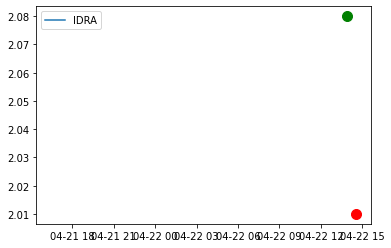

now=2020-04-22 10:17:51.946072
HOTH analysis for run 423 with profit -34.93


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1741.51,-1741.51,buy,2020-04-22 14:17:51.946072,3.49,"[3.2, 3.25, 3.25, 3.2678, 3.29, 3.3]",[3.88],499,"{'avg': 3.3619, 'rsi': 65.59130555579763, 'macd': [0.02565534365072164, 0.026589504951477494, 0.02753690192555691, 0.03021492631350453, 0.037712353668010845], 'vwap': 3.49, 'sell_macd': [0.013512813289342063, 0.014191286322534413, 0.014873326526028574, 0.016676561405036594, 0.021605360513289096], 'slow macd': [0.035623712929889084, 0.03593378457543084, 0.03626554775739388, 0.036963798413398585, 0.0386986323061671], 'macd_signal': [0.03115151376873832, 0.030239112005286155, 0.029698669989340308, 0.029801921254173153, 0.031384007736940694], 'resistances': [3.88], 'sell_macd_signal': [0.016961776554418932, 0.016407678508042027, 0.016100808111639338, 0.01621595877031879, 0.01729383911891285]}",4.06,3.3
1,-34.93,1706.58,sell,2020-04-22 15:01:19.552229,3.42,None,None,499,"{'avg': 3.4101, 'rsi': 45.315321122511364, 'vwap': 3.4389, 'reasons': 'below cost & macd negative', 'movement': -0.014641833810888356, 'sell_macd': [0.004569162583731412, 0.004114859690508954, 0.003987937180329304, 0.0019982840921328737, -0.00015467005571023762], 'sell_macd_signal': [0.004605529527258791, 0.004507395559908823, 0.004403503883992919, 0.00392245992562091, 0.003107033929354681]}",4.06,3.3


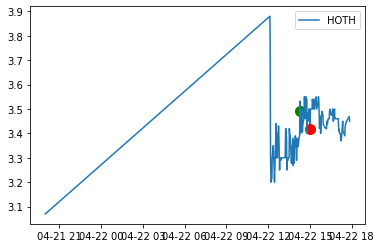

now=2020-04-22 10:40:03.904494
FULC analysis for run 423 with profit -3174.22


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3174.22,-3174.22,buy,2020-04-22 14:40:03.904494,11.06,"[9.61, 9.75, 9.7827, 9.8088, 10.14, 10.17, 10.19, 10.19, 10.29, 10.305, 10.31, 10.42, 10.42, 10.5, 10.5, 10.5, 10.55, 10.57, 10.6285, 10.64, 10.72, 10.74, 10.7513, 10.7947, 10.97, 11.0, 11.02, 11.06]","[11.175, 11.31, 11.31, 11.3706, 11.43, 11.6, 11.71, 11.79, 11.84, 11.96, 12.07]",287,"{'avg': 10.8355, 'rsi': 58.38751133565573, 'macd': [0.08841546009311863, 0.08244472778265433, 0.09597256169573498, 0.10069126277640272, 0.10802709681081168], 'vwap': 11.0425, 'sell_macd': [0.05066912109912636, 0.04669038990966001, 0.05545124365930043, 0.05844085380630304, 0.06312833114414396], 'slow macd': [0.04723450158986253, 0.04838861589020915, 0.05321151174847927, 0.056604009678462575, 0.060594302240707165], 'macd_signal': [0.11013098652879857, 0.10459373477956972, 0.10286950016280277, 0.10243385268552277, 0.10355250151058056], 'resistances': [11.175, 11.31, 11.31, 11.3706, 11.43, 11.6, 11.71, 11.79, 11.84, 11.96, 12.07], 'sell_macd_signal': [0.06593445422278682, 0.06208564136016146, 0.06075876181998925, 0.06029518021725201, 0.060861810402630404]}",12.05,10.73


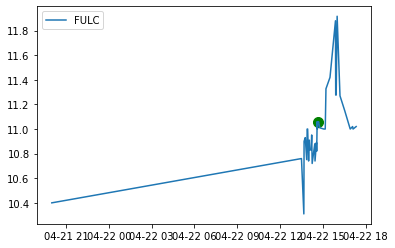

now=2020-04-22 10:02:44.921715
PLYM analysis for run 423 with profit -2326.06


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2326.06,-2326.06,buy,2020-04-22 14:02:44.921715,11.99,"[11.1, 11.15, 11.16, 11.21, 11.26, 11.34, 11.35, 11.35, 11.38, 11.51]",[12.2465],194,"{'avg': 11.7154, 'rsi': 59.99917908141828, 'macd': [0.17886284452022672, 0.17777649610359525, 0.1748994254512084, 0.18182024559020604, 0.1851705149801326], 'vwap': 11.99, 'sell_macd': [0.11356477768872253, 0.11212462864597583, 0.10954627057830457, 0.11338720882975117, 0.11490758657334865], 'slow macd': [0.044871834388427345, 0.04992336098920269, 0.05449108160672722, 0.06084548417149982, 0.06659442394153459], 'macd_signal': [0.1279902089971668, 0.13794746641845249, 0.14533785822500367, 0.15263433569804413, 0.15914157155446182], 'resistances': [12.2465], 'sell_macd_signal': [0.08255504474504771, 0.08846896152523334, 0.09268442333584759, 0.09682498043462831, 0.10044150166237238]}",13.46,11.5


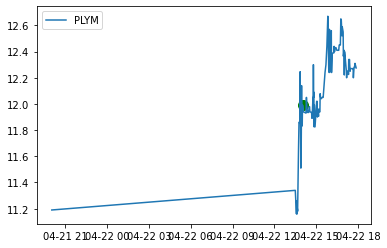

In [14]:
for run_id, count in runs.items():
    for symbol in minute_history:    
        if symbol not in trade_details[run_id]:
            continue
        start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d").date()
        minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
        plt.plot(minute_history[symbol]["close"][minute_history_index:], label=symbol)

        delta = 0
        profit = 0
        
        operations = []
        deltas = []
        profits = []
        times = []
        prices = []
        qtys = []
        indicators = []
        target_price = []
        stop_price = []
        resistances = []
        supports = []
        for trade in trade_details[run_id][symbol]:
            resistance = None
            support = None
            if trade[0] == 'buy':
                resistance = find_resistance(trade[2], minute_history[symbol], trade[1])
                support = find_support(trade[2], minute_history[symbol], trade[1])
                
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            profit += delta
            plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' or trade[0] == 'sell_short' else 'r', s=100)
            deltas.append(round(delta, 2))
            profits.append(round(profit, 2))
            operations.append(trade[0])
            times.append(pd.to_datetime(trade[1]))
            prices.append(trade[2])
            qtys.append(trade[3])
            indicators.append(trade[4])
            target_price.append(trade[6])
            stop_price.append(trade[5])    
            resistances.append(resistance)
            supports.append(support)
        d = {
            'profit': profits,
            'trade': deltas,
            'operation': operations,
            'at': times,
            'price': prices,
            'support': supports,
            'resistance': resistances,
            'qty': qtys,
            'indicators': indicators,
            'target price': target_price,
            'stop price': stop_price
        }   
        print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
        display(HTML(pd.DataFrame(data=d).to_html()))
        plt.legend()
        plt.show()

In [ ]:
for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            print(symobl)
            continue
           
        print (f'{symbol} analysis for run {run_id}')
        plt.plot(minute_history[symbol]['close'], label=symbol)

        for trade in trade_details[run_id][symbol]:
            print(f'operation {trade[0]} price {trade[2]} qty {trade[3]}')

            plt.scatter(parser.isoparse(trade[1]), trade[2], c='g' if trade[0] == 'buy' else 'r', s=100)
    
        plt.legend()
        plt.show()

        min_time = trade_details[run_id][symbol][0][0]
        max_time = trade_details[run_id][symbol][-1][2]
        delta = 0 
        accumulative_delta = []
        
  #      if min_time not in minute_history[symbol]['close'] or max_time not in minute_history[symbol]['close']:
  #          continue
        plt.plot(minute_history[symbol]['close'][min_time:max_time], label=symbol)
                

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
 #           t = parser.isoparse(trade[0])
 #           t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
 #           if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
 #               continue 

                
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            trade_delta = trade[3] - trade[1]
            delta += trade_delta 
            accumulative_delta.append(delta)
            
        plt.legend()
        plt.show()

        print(f'Delta = {delta}')
        plt.plot(range(len(accumulative_delta)), accumulative_delta)
        plt.show()

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
#            t = parser.isoparse(trade[0])
#            t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
#            if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
#                continue

                
            plt.plot(minute_history[symbol]['close'][trade[0]:trade[2]])
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            plt.show()
            print(f"buy time:{trade[0]} sell time:{trade[2]}")
            print(trade[4])
            print(trade[5])



In [60]:
 pd.Timestamp('2020-04-16 13:44:06.066') 

Timestamp('2020-04-16 13:44:06.066000')

In [61]:
index = minute_history['NURO'].index.get_loc(pd.Timestamp('2020-04-16 13:44:06.066') , method='nearest')

2416

In [62]:
minute_history['NURO'][:index]

,open,high,low,close,volume
timestamp,,,,,
2020-04-06 07:18:00-04:00,1.040,1.040,1.030,1.030,2689.0
2020-04-06 07:31:00-04:00,1.010,1.010,1.010,1.010,200.0
2020-04-06 07:49:00-04:00,1.030,1.030,1.030,1.030,300.0
2020-04-06 09:28:00-04:00,1.060,1.060,1.060,1.060,106.0
2020-04-06 09:30:00-04:00,1.000,1.090,1.000,1.090,9920.0
...,...,...,...,...,...
2020-04-06 12:39:00-04:00,0.990,0.990,0.990,0.990,100.0
2020-04-06 12:40:00-04:00,0.993,0.993,0.993,0.993,1000.0
2020-04-06 12:42:00-04:00,1.000,1.000,0.980,0.980,10461.0


In [68]:
series = minute_history['NURO'][:2417]['close']

In [70]:
MACD(series.dropna().between_time("9:30", "16:00"))

(timestamp
 2020-04-06 09:30:00-04:00         NaN
 2020-04-06 09:32:00-04:00         NaN
 2020-04-06 09:35:00-04:00         NaN
 2020-04-06 09:38:00-04:00         NaN
 2020-04-06 09:39:00-04:00         NaN
                                ...   
 2020-04-16 13:40:00-04:00    0.190075
 2020-04-16 13:41:00-04:00    0.194543
 2020-04-16 13:42:00-04:00    0.189046
 2020-04-16 13:43:00-04:00    0.188320
 2020-04-16 13:44:00-04:00    0.179718
 Length: 1883, dtype: float64,
 timestamp
 2020-04-06 09:30:00-04:00         NaN
 2020-04-06 09:32:00-04:00         NaN
 2020-04-06 09:35:00-04:00         NaN
 2020-04-06 09:38:00-04:00         NaN
 2020-04-06 09:39:00-04:00         NaN
                                ...   
 2020-04-16 13:40:00-04:00    0.111862
 2020-04-16 13:41:00-04:00    0.128398
 2020-04-16 13:42:00-04:00    0.140528
 2020-04-16 13:43:00-04:00    0.150086
 2020-04-16 13:44:00-04:00    0.156013
 Length: 1883, dtype: float64,
 timestamp
 2020-04-06 09:30:00-04:00         NaN
 2020-04